1. 열에 전체 평균 추가

2. 열에 중앙값 추가

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. 데이터 가져오기

In [2]:
t_bat16=pd.read_csv("C:/Users/a/Desktop/2020빅콘/제공데이터/제공데이터(.CSV)_시즌별, 시트별 구분/2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2016.csv",encoding='utf-8',engine='python')
t_bat17=pd.read_csv("C:/Users/a/Desktop/2020빅콘/제공데이터/제공데이터(.CSV)_시즌별, 시트별 구분/2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2017.csv",encoding='utf-8',engine='python')
t_bat18=pd.read_csv("C:/Users/a/Desktop/2020빅콘/제공데이터/제공데이터(.CSV)_시즌별, 시트별 구분/2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2018.csv",encoding='utf-8',engine='python')
t_bat19=pd.read_csv("C:/Users/a/Desktop/2020빅콘/제공데이터/제공데이터(.CSV)_시즌별, 시트별 구분/2020빅콘테스트_스포츠투아이_제공데이터_팀타자_2019.csv",encoding='utf-8',engine='python')

In [3]:
#모든 열 다 출력하기
pd.options.display.max_columns=None

## 2. train test 셋 만들기

In [4]:
team=['HH', 'HT', 'KT', 'LG', 'LT', 'NC', 'OB', 'SK', 'SS', 'WO']

In [5]:
def make_data(train,answer):
    train['HIT_RATE']=train['HIT']/train['AB']
    tr=train[['T_ID','HIT_RATE']]  #경기당 팀과 타율만 남김
    num=list(range(1,int((len(train)/10)+1)))*10  #팀별 경기순서 추가
    tr=tr.assign(order=num)
    tr=tr.pivot(index='T_ID',columns='order',values='HIT_RATE') #팀당 경기별 타율 데이터셋 만들기
    
    data=pd.merge(tr,answer,on='T_ID') #팀별 앞124경기와 후20경기 결과 합치기
    return data

In [6]:
#정답 셋과 train 셋 만드는 함수
t_bat=[t_bat16,t_bat17,t_bat18,t_bat19]
def make_answer_train(year):
    a=t_bat[year-2016][['T_ID','AB','HIT']][140:]  #각 팀당 앞 14경기 버리기
    data=pd.DataFrame()  #빈 데이터프레임 만들기

    train_name=['train' + str(i) for i in range(1,5)]
    train=[pd.DataFrame() for var in train_name] #50경기씩 묶일 데이터셋
    
    ans_name=['ans' + str(i) for i in range(1,5)]
    answer=[pd.DataFrame() for var in ans_name]  #20경기씩 묶일 데이터셋
        
    for i in range(4):
        tra=train[i]
        ans=answer[i]
        for t in team:
            tra=pd.concat([tra,a[a['T_ID']==t][i*20:50+i*20]])
            ans=pd.concat([ans,a[a['T_ID']==t][50+i*20:70+i*20]])

        #팀별 AB,HIT합 구하기
        ans=ans.groupby(['T_ID']).sum()
        ans['HIT_RATE']=ans['HIT']/ans['AB'] #타율 계산
        ans=ans.drop(ans.columns[[0,1]],axis='columns')

        if i <3:
            d=make_data(tra,ans)
            data=pd.concat([data,d])
        else:
            test=make_data(tra,ans)
            
    data['mean']=data.mean(axis=1)
    test['mean']=test.mean(axis=1)
        
    return data,test

In [7]:
train16,test16=make_answer_train(2016)
train17,test17=make_answer_train(2017)
train18,test18=make_answer_train(2018)
train19,test19=make_answer_train(2019)

## 3. 모델학습

In [8]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

In [9]:
# 모델 모듈
import xgboost
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [10]:
X_cols=list(range(1,51))+['mean']
Y_col=['HIT_RATE']

In [11]:
#### 학습시킬 모델
model_dict = {'xgb':XGBRegressor(n_estimators=100, learning_rate=0.05 ,max_depth=3, random_state=23),
    'lgbm':LGBMRegressor(),
    'rf':RandomForestRegressor(),
    'svr':SVR(),
    'reg':LinearRegression(),
    'ridge':Ridge(alpha=100,normalize=True),
    'lasso':Lasso(alpha=0.05,normalize=True)}  #변수 자동 채택 / 많은 변수를 다룰때 활용

*ridge : 모든 변수를 가지고 계수값을 줄임(모델 복잡/성능저하)

*lasso : 변수들끼리 correlate하면 한개의 변수만 채택(정보손실 / 정확성 떨어질수있음)

In [63]:
train=train19
test=test18

In [64]:
X_train = train[X_cols]; Y_train = train[Y_col]
X_test = test[X_cols]; Y_test = test[Y_col]
diff=[]

#모델 여러개 돌려보기
model_list=['xgb','lgbm','rf','svr','reg','ridge','lasso']
for m in model_list:
    model = model_dict[m]
    if m=='rf': Y_train=Y_train.values.ravel()  #rf에서의 오류 없애기 위함
    weight = train['mean']
    model.fit(X_train, Y_train, sample_weight=weight)
    Y_predict = model.predict(X_test)

    r2=r2_score(Y_test, Y_predict)

    a=Y_test.assign(predict=Y_predict)
    a['diff']=a['HIT_RATE']-a['predict']
    print(m,"\t>r2 :", r2,'\ttrain점수 :{:.3f}'.format(model.score(X_train,Y_train)),"\t차이합 :",abs(a['diff']).sum())
    diff.append(r2)

xgb 	>r2 : -0.7008983397792139 	train점수 :0.963 	차이합 : 0.14035300153065922
lgbm 	>r2 : -0.9560449993851592 	train점수 :-0.000 	차이합 : 0.1643996115266706
rf 	>r2 : -0.6228506451571265 	train점수 :0.838 	차이합 : 0.1515087488937799
svr 	>r2 : -0.45918198515576103 	train점수 :-0.063 	차이합 : 0.1424858018336509
reg 	>r2 : -17.440660401898974 	train점수 :1.000 	차이합 : 0.6043257667675115
ridge 	>r2 : -1.01337037431807 	train점수 :0.035 	차이합 : 0.1678739638551876
lasso 	>r2 : -0.9560451115449791 	train점수 :-0.000 	차이합 : 0.164399617019642


In [20]:
#r2가 가장 큰 모델 돌리기
model = model_dict[model_list[diff.index(max(diff))]]
if m=='rf': Y_train=Y_train.values.ravel()  #rf에서의 오류 없애기 위함
weight = train['mean']
model.fit(X_train, Y_train, sample_weight=weight)
Y_predict = model.predict(X_test)
print(model_list[diff.index(max(diff))])

rf


### 예측값과 실제값 차이

Text(0,0.5,'예측 값')

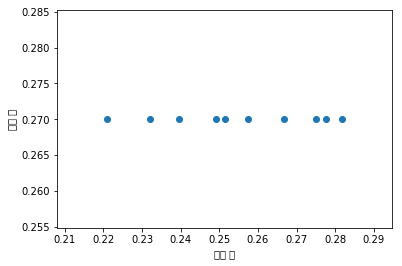

In [14]:
# 예측값과 실제값의 시각화
plt.scatter(Y_test, Y_predict)
plt.xlabel("실제 값")
plt.ylabel("예측 값")

In [15]:
#예측값과 실제값 차이
a=Y_test
a=a.assign(predict=Y_predict)
a['diff']=a['HIT_RATE']-a['predict']
a

,HIT_RATE,predict,diff
T_ID,,,
HH,0.266764,0.270033,-0.003269
HT,0.249245,0.270033,-0.020788
KT,0.277691,0.270033,0.007658
LG,0.257485,0.270033,-0.012548
LT,0.220877,0.270033,-0.049155
NC,0.275109,0.270033,0.005076
OB,0.281690,0.270033,0.011657
SK,0.239695,0.270033,-0.030338
SS,0.232061,0.270033,-0.037972


In [16]:
#차이 합
abs(a['diff']).sum()

0.19701556346616975

### 엑셀파일로 만들기

In [65]:
train16.to_csv("C:/Users/a/Desktop/train16.csv")
test16.to_csv("C:/Users/a/Desktop/test16.csv")
train17.to_csv("C:/Users/a/Desktop/train17.csv")
test17.to_csv("C:/Users/a/Desktop/test17.csv")
train18.to_csv("C:/Users/a/Desktop/train18.csv")
test18.to_csv("C:/Users/a/Desktop/test18.csv")
train19.to_csv("C:/Users/a/Desktop/train19.csv")
test19.to_csv("C:/Users/a/Desktop/test19.csv")